-----------
#### code implementation of page 76-77 from the Richard Sutton
-------------------

In [1]:
!pip install lolviz

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------------------------- ------------- 30.7/47.1 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 1.2 MB/s eta 0:00:00
  Created wheel for lolviz: filename=lolviz-1.4.4-py3-none-any.whl size=9810 sha256=c3b7b004ed663e4294656e297dcfcb6d9201e96cc7eab97db2fa25a35d85cce9
  Stored in directory: c:\users\bhupe\appdata\local\pip\cache\wheels\0b\9f\07\1f985380ba6ff8dc6e398945ebd689704c3a01e999d5dbfe4d
Successfully built lolviz


In [2]:
!pip install graphviz

In [4]:
import matplotlib.pyplot as plt                 # type: ignore
import pandas as pd                             # type: ignore

from gridWorldEnvironment import GridWorld      # type: ignore

import numpy as np                              # type: ignore 
import seaborn as sns                           # type: ignore 
from lolviz import *                            # type: ignore

In [5]:
# parameters
gamma      = 1 # discounting rate
rewardSize = -1
gridSize   = 4

terminationStates = [0, 15]

In [6]:
# creating gridworld environment
gw = GridWorld( gamma     = gamma,
                rewardSize= rewardSize,
                gridSize  = gridSize,
                )

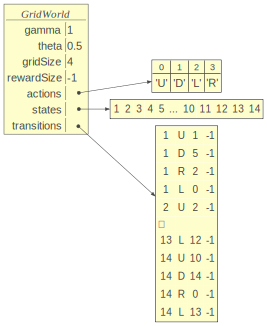

In [7]:
objviz(gw)   

In [8]:
print("Actions: ", gw.actions)
print("States: ",  gw.states)

Actions:  ('U', 'D', 'L', 'R')
States:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


#### State Transitions
- All possible state transitions in `deterministic` gridworld
- Each `transition` is a quadruple of (state, action, next state, reward)
    - For instance, first row implies that in if the agent performs action U (upwards) in state 1, it ends up at state 1 again (not moving) with -1 reward

In [9]:
gw.transitions

array([[1, 'U', 1, -1],
       [1, 'D', 5, -1],
       [1, 'R', 2, -1],
       [1, 'L', 0, -1],
       [2, 'U', 2, -1],
       [2, 'D', 6, -1],
       [2, 'R', 3, -1],
       [2, 'L', 1, -1],
       [3, 'U', 3, -1],
       [3, 'D', 7, -1],
       [3, 'R', 3, -1],
       [3, 'L', 2, -1],
       [4, 'U', 0, -1],
       [4, 'D', 8, -1],
       [4, 'R', 5, -1],
       [4, 'L', 4, -1],
       [5, 'U', 1, -1],
       [5, 'D', 9, -1],
       [5, 'R', 6, -1],
       [5, 'L', 4, -1],
       [6, 'U', 2, -1],
       [6, 'D', 10, -1],
       [6, 'R', 7, -1],
       [6, 'L', 5, -1],
       [7, 'U', 3, -1],
       [7, 'D', 11, -1],
       [7, 'R', 7, -1],
       [7, 'L', 6, -1],
       [8, 'U', 4, -1],
       [8, 'D', 12, -1],
       [8, 'R', 9, -1],
       [8, 'L', 8, -1],
       [9, 'U', 5, -1],
       [9, 'D', 13, -1],
       [9, 'R', 10, -1],
       [9, 'L', 8, -1],
       [10, 'U', 6, -1],
       [10, 'D', 14, -1],
       [10, 'R', 11, -1],
       [10, 'L', 9, -1],
       [11, 'U', 7, -1],
    

In [10]:
print(gw.state_transition(12, "U"))
print(gw.state_transition(13, "L"))

(8, -1)
(12, -1)


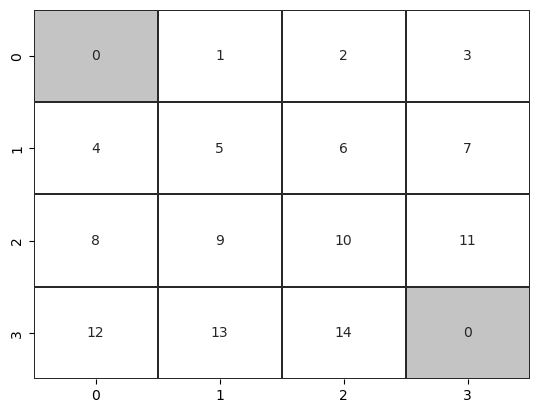

In [11]:
gw.show_environment()

#### Generate random episode
- For Monte Carlo methods, `random episodes` from `starting state` to `terminal` state should be generated in advance
    - Random episode below follows `equiprobable random policy` (i.e., same probabilities for each action)

In [12]:
def generate_random_episode(env):
    episode = []
    done    = False
    
    current_state = np.random.choice(env.states)
    
    episode.append((current_state, -1))
    
    while not done:

        action = np.random.choice(env.actions)
        
        next_state, reward = gw.state_transition(current_state, action)
        
        episode.append((next_state, reward))
        
        if next_state == 0:
            done = True
            
        current_state = next_state
        
    return episode

In [16]:
generate_random_episode(gw)

[(9, -1),
 (10, -1),
 (6, -1),
 (2, -1),
 (1, -1),
 (2, -1),
 (6, -1),
 (7, -1),
 (6, -1),
 (10, -1),
 (9, -1),
 (10, -1),
 (11, -1),
 (11, -1),
 (10, -1),
 (9, -1),
 (8, -1),
 (9, -1),
 (5, -1),
 (4, -1),
 (0, -1)]

Initialize value functions of states to 0

In [17]:
def value_array(env):
    return np.zeros(len(env.states)+2)

#### First-visit MC Prediction
- Estimates $v_\pi(s)$ as the average of the returns following first visit to $s$
    - Most widely studied (from 1940s)

In [18]:
returns = dict()

for state in gw.states:
    returns[state] = list()

In [19]:
returns

{1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: []}

In [20]:
#nbr_cycles_of_MC_run    = 9
nbr_episodes_each_cycle = 100
#number_plots_per_row    = 3

# FV_V = dict()

# FV_policy = dict()
# FV_policy_dirs_chars = dict()

# fig, ax = plt.subplots( nrows  = nbr_cycles_of_MC_run//number_plots_per_row, 
#                         ncols  = number_plots_per_row, 
#                         figsize= (30, 20))

# fig.suptitle('Monte Carlo estimates - FIRST VISIT method, note : lighter the color, better the value fn\n\n', fontsize=28)

values  = value_array(gw)
returns = dict()

for state in gw.states:
    returns[state] = list()

#for cycle in range(nbr_cycles_of_MC_run):

for i in range(nbr_episodes_each_cycle):
    episode = generate_random_episode(gw)
    
    already_visited = set({0})             # also exclude terminal state (0)
    
    for s, r in episode:
        if s not in already_visited:
            
            already_visited.add(s)
            
            idx = episode.index((s, r))
            
            G = 0
            j = 1
            
            while j + idx < len(episode):
                G  = gw.gamma * (G + episode[j + idx][1])
                j += 1
                
            returns[s].append(G)
            values[s] = np.mean(returns[s])

    V = np.array(values).reshape(4,4)

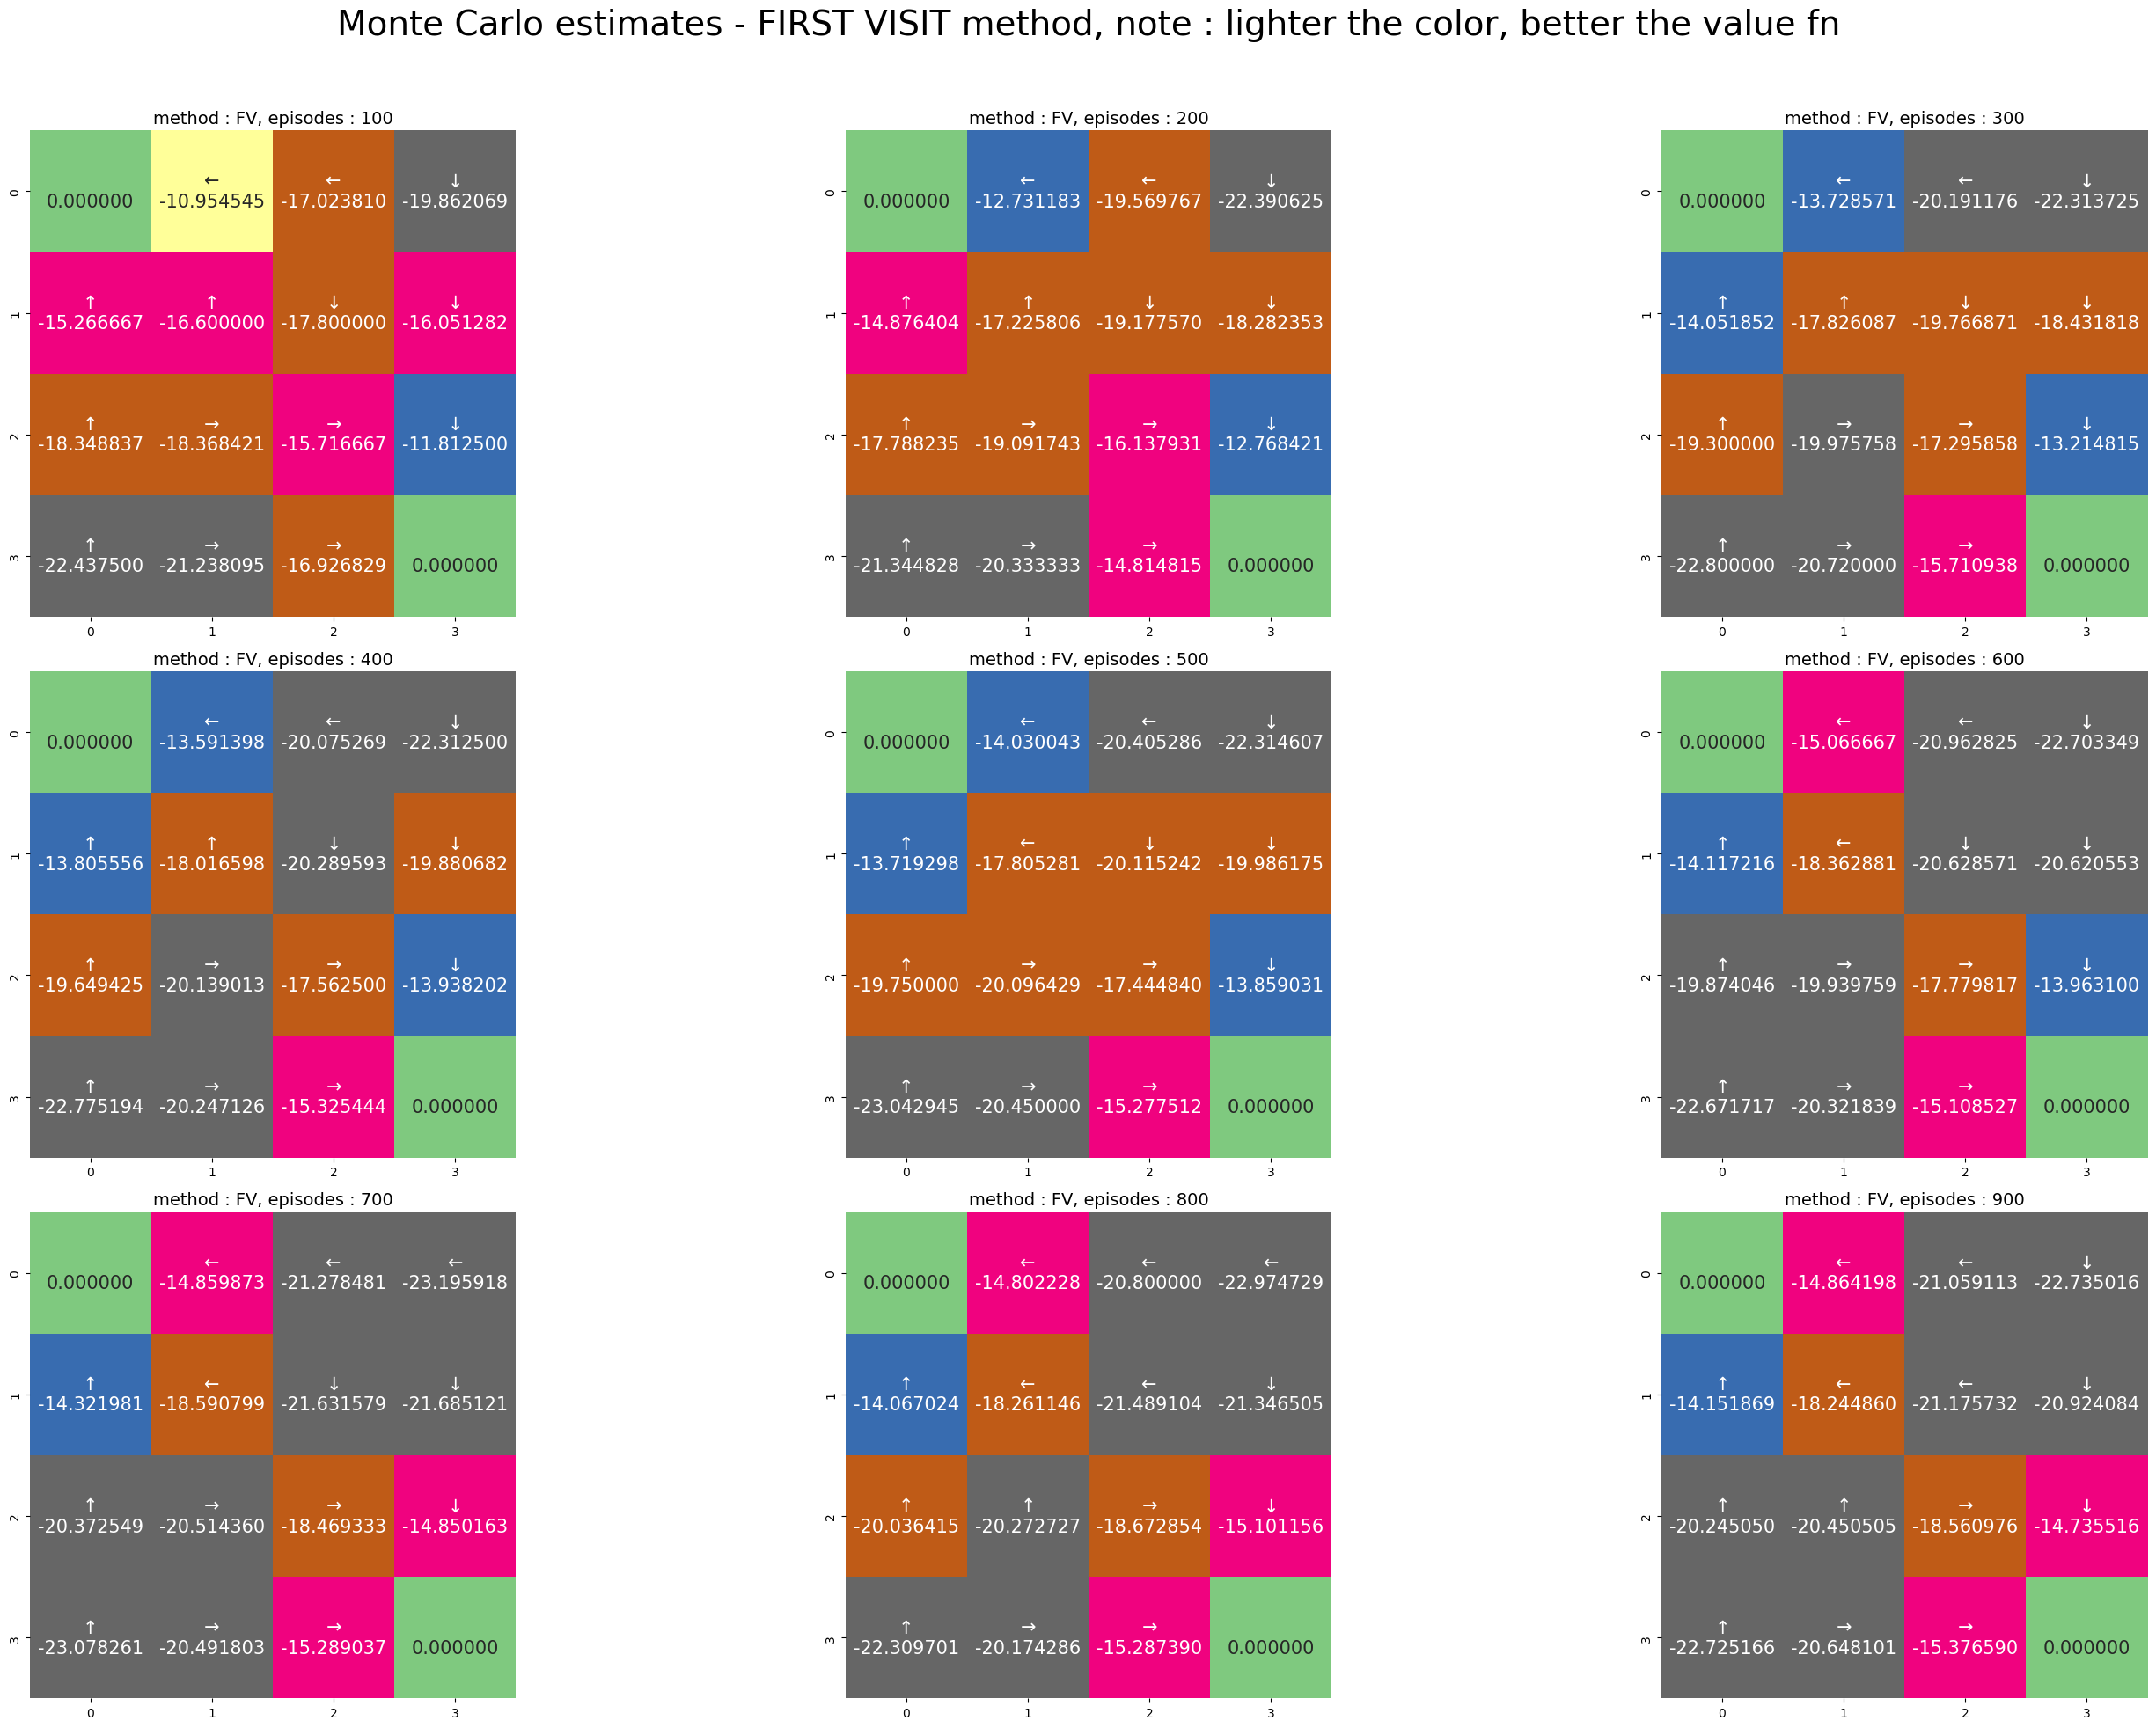

In [21]:
nbr_cycles_of_MC_run    = 9
nbr_episodes_each_cycle = 100
number_plots_per_row    = 3

FV_V = dict()

FV_policy = dict()
FV_policy_dirs_chars = dict()

fig, ax = plt.subplots( nrows  = nbr_cycles_of_MC_run//number_plots_per_row, 
                        ncols  = number_plots_per_row, 
                        figsize= (30, 20))

fig.suptitle('Monte Carlo estimates - FIRST VISIT method, note : lighter the color, better the value fn\n\n', fontsize=28)

values  = value_array(gw)
returns = dict()

for state in gw.states:
    returns[state] = list()

for cycle in range(nbr_cycles_of_MC_run):

    for i in range(nbr_episodes_each_cycle):
        episode = generate_random_episode(gw)   # random number of randomly generated sequences
        
        already_visited = set({0})             # also exclude terminal state (0)
        
        for s, r in episode:
            if s not in already_visited:
                
                already_visited.add(s)
                
                idx = episode.index((s, r))
                
                G = 0
                j = 1
                
                while j + idx < len(episode):
                    G = gw.gamma * (G + episode[j + idx][1])
                    j += 1
                    
                returns[s].append(G)
                values[s] = np.mean(returns[s])

    V = np.array(values).reshape(4,4)
    policy, all_dirs_chars = gw.get_policy(V)

    FV_V['FV-'+str((cycle+1)*nbr_episodes_each_cycle)] = V
    FV_policy['FV-'+str((cycle+1)*nbr_episodes_each_cycle)]= policy
    FV_policy_dirs_chars['FV-'+str((cycle+1)*nbr_episodes_each_cycle)] = all_dirs_chars

    sns.heatmap(V, 
            annot=policy, 
            fmt='', 
            cbar=False,
            square=True, 
            cmap='Accent_r',
            annot_kws={"size":15},
            ax=ax[cycle//number_plots_per_row, cycle%number_plots_per_row]
            )

    ax[cycle//number_plots_per_row, cycle%number_plots_per_row].set_title('method : FV, episodes : {}'.format(str((cycle+1)*nbr_episodes_each_cycle)), fontsize=14)

plt.tight_layout()